In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [3]:
pm.__version__

'5.5.0'

# Preprocess train and test data

Загрузим данные с отобранными признаками и выполним кодирование категориальных переменных:

In [4]:
train_data = pd.read_csv("../datasets/selected_train.csv")
train_num_data = train_data.select_dtypes(include = ['float64', 'int64']).drop(['SalePrice'], axis=1)
train_cat_data = train_data.select_dtypes(exclude = ['float64', 'int64'])
train_target = train_data['SalePrice'].to_list()

In [5]:
test_data = pd.read_csv("../datasets/selected_test.csv")
test_num_data = test_data.select_dtypes(include = ['float64', 'int64'])
test_cat_data = test_data.select_dtypes(exclude = ['float64', 'int64'])

In [6]:
categorial_data = pd.concat([train_cat_data, test_cat_data])
oe = OrdinalEncoder()
oe.fit(categorial_data)

train_cat_data_ordinal = oe.transform(train_cat_data)
train_cat_data_ordinal = pd.DataFrame(train_cat_data_ordinal, columns=categorial_data.columns)

test_cat_data_ordinal = oe.transform(test_cat_data)
test_cat_data_ordinal = pd.DataFrame(test_cat_data_ordinal, columns=categorial_data.columns )

In [7]:
train_preprocessed = pd.concat([train_cat_data_ordinal, train_num_data], axis=1)
train_preprocessed.head(3)

,LotShape,LandSlope,Neighborhood,BldgType,HouseStyle,Exterior1st,Exterior2nd,BsmtFinType1,HeatingQC,GarageType,...,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,Fireplaces,GarageCars,WoodDeckSF,OpenPorchSF,ScreenPorch
0,3.0,0.0,5.0,0.0,5.0,12.0,13.0,2.0,0.0,1.0,...,1710,1,2,1,3,0,2,0,61,0
1,3.0,0.0,24.0,0.0,2.0,8.0,8.0,0.0,0.0,1.0,...,1262,0,2,0,3,1,2,298,0,0
2,0.0,0.0,5.0,0.0,5.0,12.0,13.0,2.0,0.0,1.0,...,1786,1,2,1,3,1,2,0,42,0


In [8]:
test_preprocessed = pd.concat([test_cat_data_ordinal, test_num_data], axis=1)
test_preprocessed.head(3)

,LotShape,LandSlope,Neighborhood,BldgType,HouseStyle,Exterior1st,Exterior2nd,BsmtFinType1,HeatingQC,GarageType,...,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,Fireplaces,GarageCars,WoodDeckSF,OpenPorchSF,ScreenPorch
0,3.0,0.0,12.0,0.0,2.0,12.0,13.0,4.0,4.0,1.0,...,896,0.0,1,0,2,0,1.0,140,0,120
1,0.0,0.0,12.0,0.0,2.0,13.0,14.0,0.0,4.0,1.0,...,1329,0.0,1,1,3,0,1.0,393,36,0
2,0.0,0.0,8.0,0.0,5.0,12.0,13.0,2.0,2.0,1.0,...,1629,0.0,2,1,3,1,2.0,212,34,0


In [9]:
submit_df = pd.read_csv("/content/sample_submission.csv")

# Baseline Models

Натренируем модели из scikit-learn:

In [10]:
rf = RandomForestRegressor()
rf.fit(train_preprocessed, train_target)
preds = rf.predict(test_preprocessed)
submit_df['SalePrice'] = preds
submit_df.to_csv("rf_submit.csv", index=False)
# Leaderboard score: 0,1491

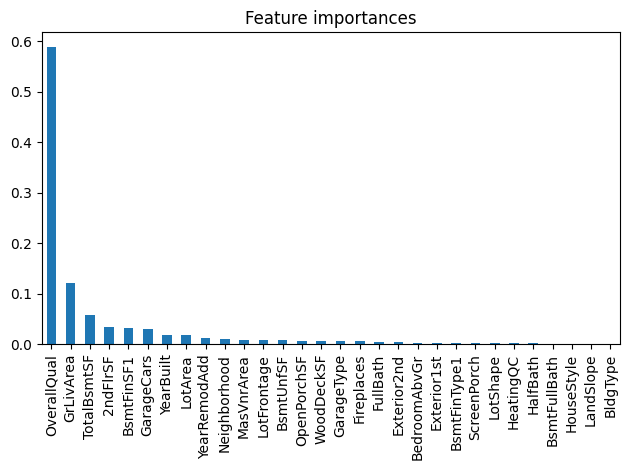

In [57]:
importances = pd.Series(rf.feature_importances_,
                        index=train_preprocessed.columns.tolist()
                        ).sort_values(ascending=False)
fig, ax = plt.subplots()
importances.plot.bar( ax=ax)
ax.set_title("Feature importances")
fig.tight_layout()

In [11]:
scaler = RobustScaler()
scaled_train = scaler.fit_transform(train_preprocessed)
scaled_test = scaler.transform(test_preprocessed)

lin_regr = LinearRegression()
lin_regr.fit(scaled_train, train_target)
preds = lin_regr.predict(scaled_test)
submit_df['SalePrice'] = preds
submit_df.to_csv("lr_submit.csv", index=False)
# Leaderboard score: 0,19222

# PYMC Linear Model

Сконструируем линейную модель при помощи PYMC:

In [125]:
observed_Y = np.array(train_target)

In [403]:
with pm.Model() as model:
  """
   Определим априорные распределения (priors) для параметров модели
   Определим priors как HalfNormal, поскольку целевая переменная больше нуля
   sigma определим большим значением - 200, поскольку мы ничего не знаем о prior
   intercept - распределение свободного члена линейной регрессии
   thetha - распределения коэффициентов линейной регрессии
   stdev - стандартное отклонение для posterior
   expected_value - целевое распределение
   y - likelihood
  """

  # Задаем имя для датасета, который будет использовать модель
  data = pm.Data("data", train_preprocessed, mutable=True)
  
  stdev = pm.HalfNormal("stdev", sigma=1.0)
  intercept = pm.HalfNormal("intercept", sigma=200.0)

  # Чтобы не создавать 30 раз переменную, укажем shape=30
  thetha= pm.HalfNormal("thetha", sigma=200, shape=30)

  expected_value = pm.math.dot(thetha, data.T) + intercept

  # указываем shape, чтобы предсказания для теста адаптировались под размер тестовой выборки
  y = pm.Normal('y', mu=expected_value, sigma=stdev, observed=observed_Y, shape=expected_value.shape)

  trace = pm.sample(1000, tune=1000)

Посмотрим как обучалась наша модель:

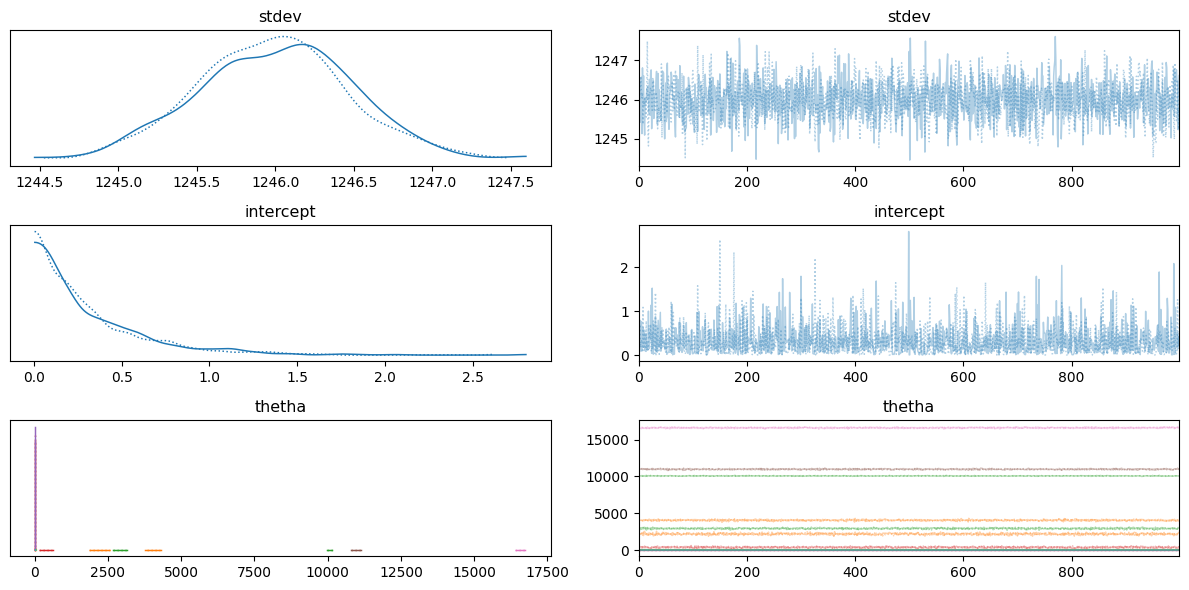

In [404]:
az.plot_trace(trace)
plt.tight_layout()
plt.show()

Посмотрим на распределение posterior:

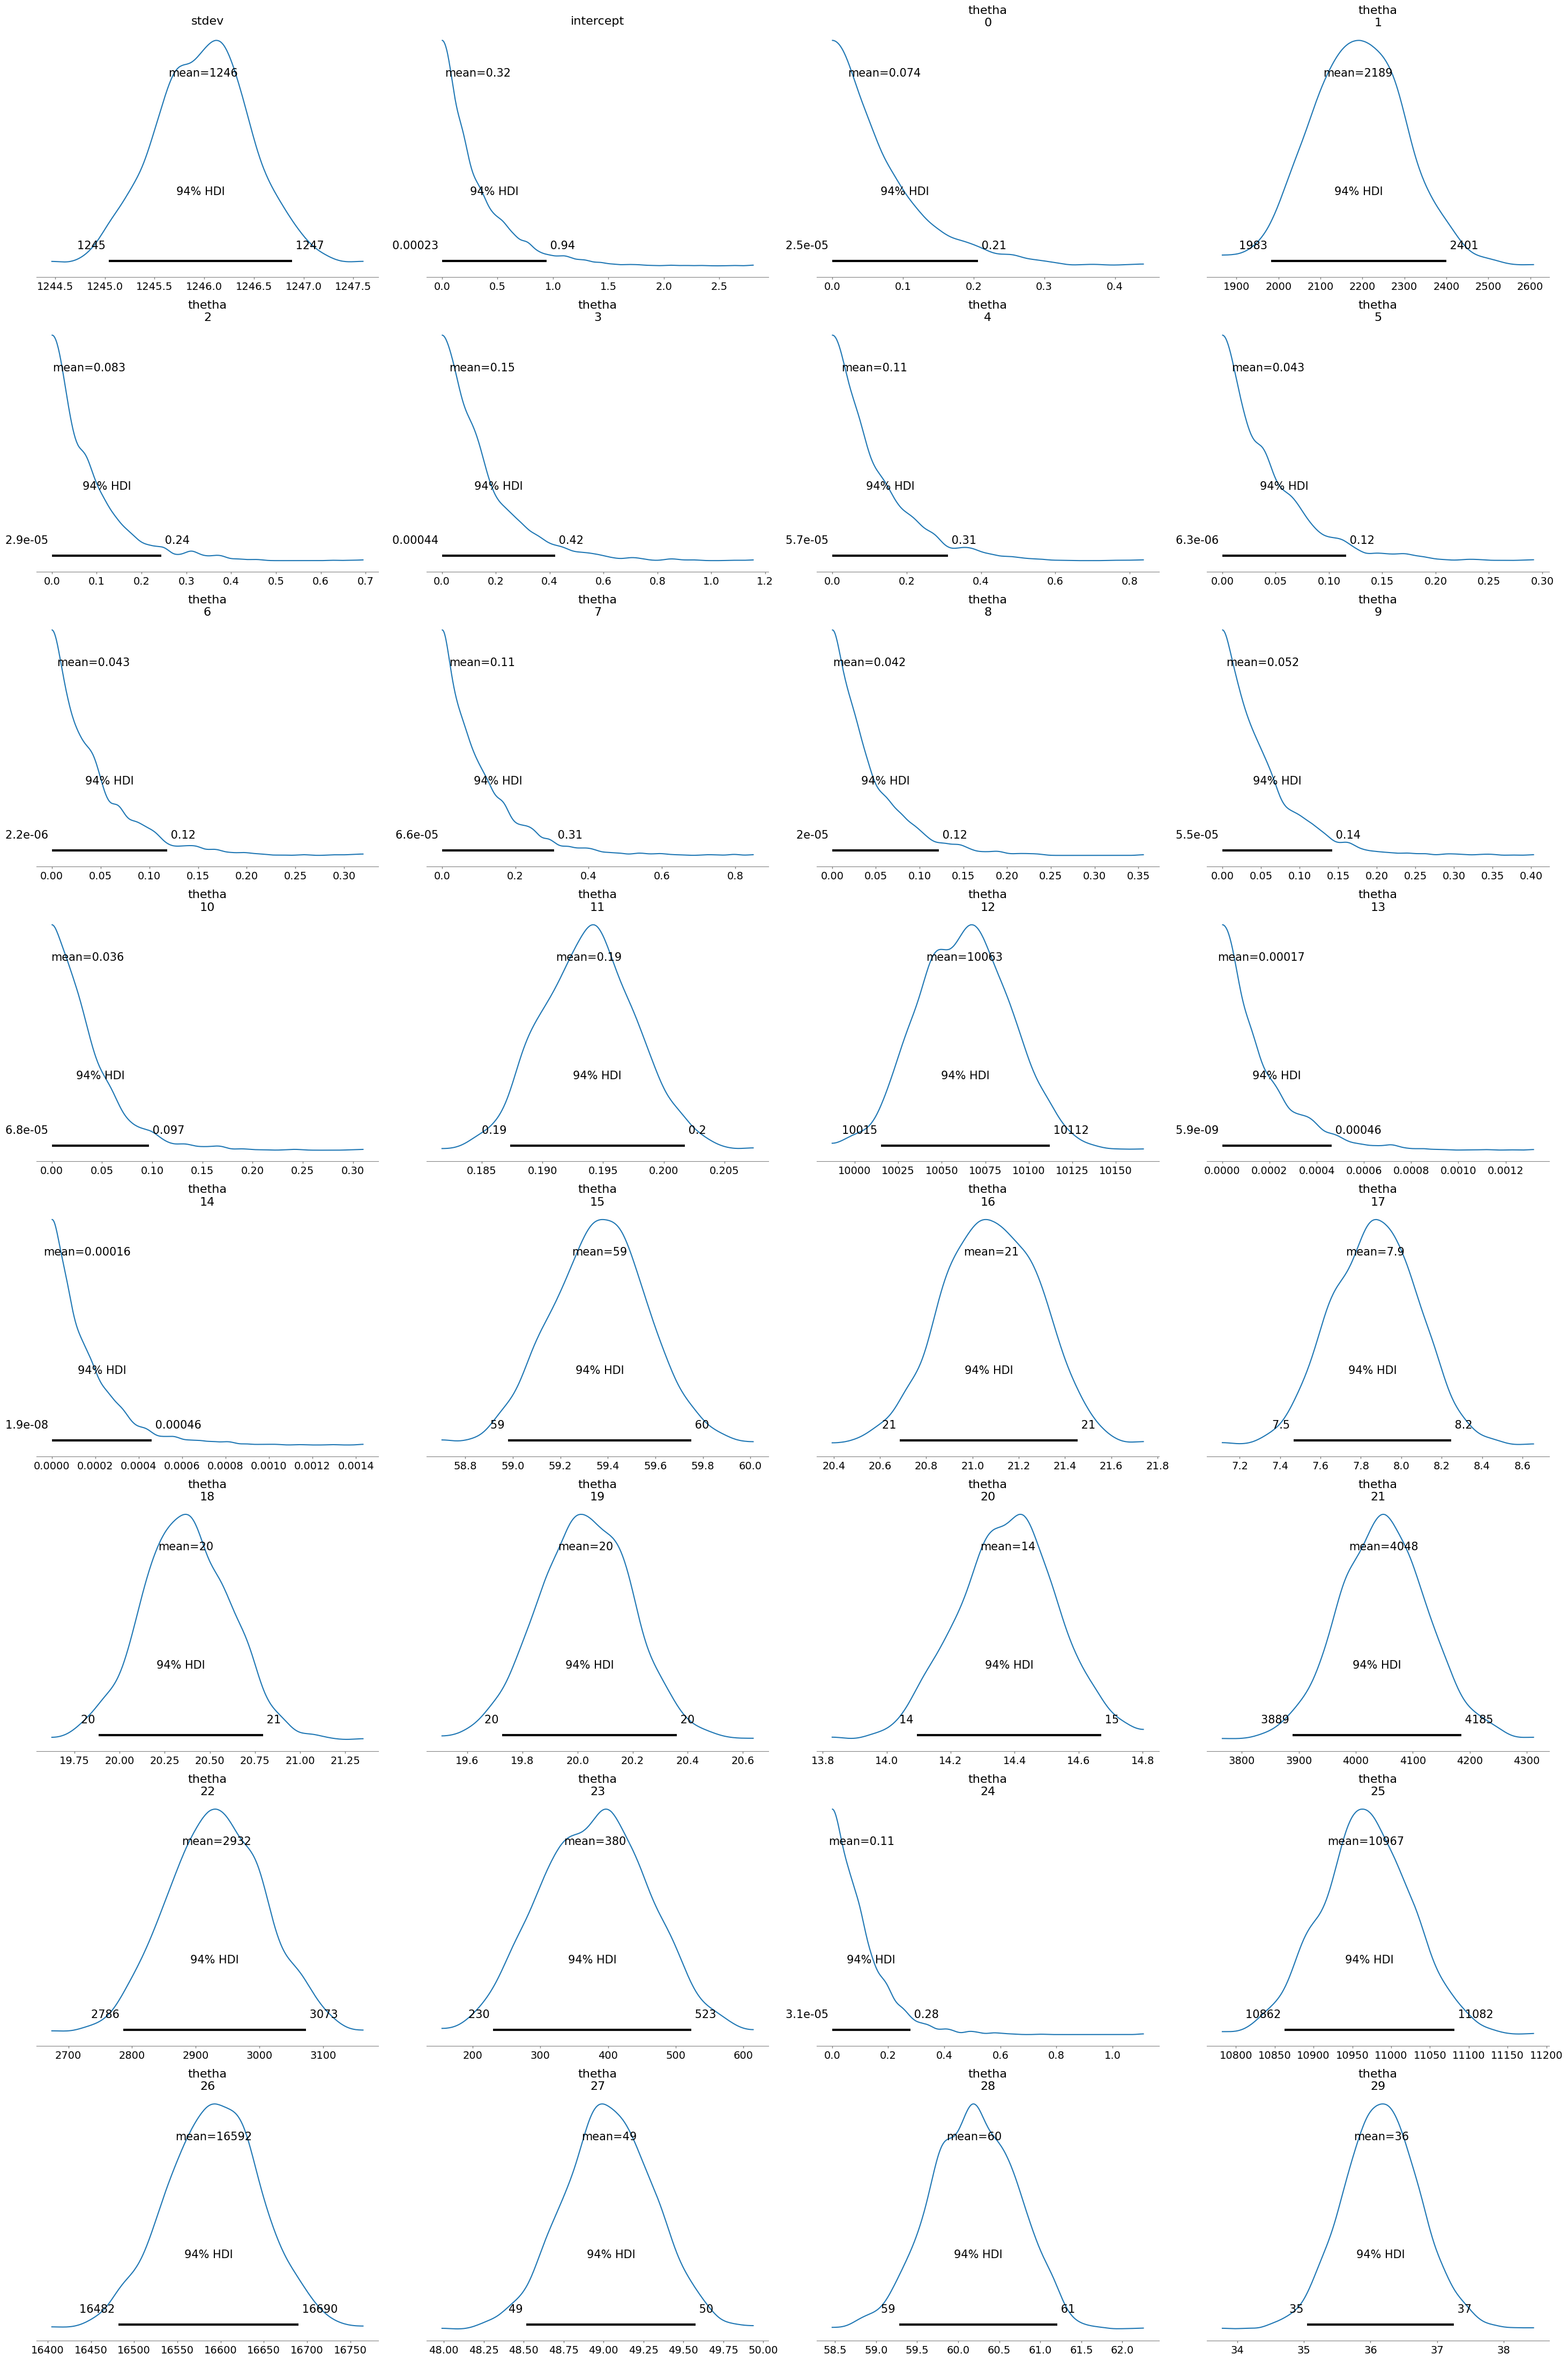

In [405]:
az.plot_posterior(trace)
plt.tight_layout()
plt.show()

Предсказания для тренировочной выборки:

In [406]:
with model:
  ppc = pm.sample_posterior_predictive(trace)
  train_preds = np.mean(ppc.posterior_predictive['y'].to_numpy(), axis=1).mean(axis=0)

  print()
  print(mean_squared_error(y_true=np.log(train_target), y_pred=np.log(train_preds), squared=False))


0.19408390203322406


Посмотрим как распределены наши предсказания относительно истинных значений:

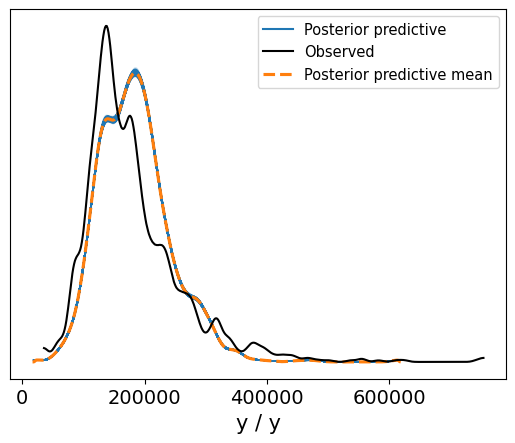

In [407]:
az.plot_ppc(ppc)
plt.show()

Выполним предсказания для тестовой выборки:

In [410]:
# Make predictions

# test_X = test_num_data[top_k_importances]
with model:
    # заменяем данные в датасете с именем data
    pm.set_data({"data" : test_preprocessed})
    y_test = pm.sample_posterior_predictive(trace, predictions=True)

In [409]:
test_preds = np.mean(y_test.predictions['y'].to_numpy(), axis=1).mean(axis=0)
submit_df['SalePrice'] = test_preds
submit_df.to_csv("pymc_lr_submit.csv", index=False)
# Leaderboard score: 0,1995